### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,models,transforms,utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=b15b47b03504ae82a3a1ad9b71d2d52b224ee5da937bbb3b403fb1a9bbfea156
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c74c5783f223a9173d8e1bbcd3f6579e6d501311a1342c9678d04fd67e4363d0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
import segmentation_models_pytorch as smp

## Create dataframe

In [4]:
labels_df=pd.read_csv("/content/drive/MyDrive/fashionDataset/labels (1).csv")
img_paths=sorted(glob("/content/drive/MyDrive/fashionDataset/jpeg_images/IMAGES/*.jpeg"))
mask_paths=sorted(glob("/content/drive/MyDrive/fashionDataset/jpeg_masks/MASKS/*.jpeg"))
df=pd.DataFrame({"img":img_paths,"mask":mask_paths})
df.head()

,img,mask
0,/content/drive/MyDrive/fashionDataset/jpeg_ima...,/content/drive/MyDrive/fashionDataset/jpeg_mas...
1,/content/drive/MyDrive/fashionDataset/jpeg_ima...,/content/drive/MyDrive/fashionDataset/jpeg_mas...
2,/content/drive/MyDrive/fashionDataset/jpeg_ima...,/content/drive/MyDrive/fashionDataset/jpeg_mas...
3,/content/drive/MyDrive/fashionDataset/jpeg_ima...,/content/drive/MyDrive/fashionDataset/jpeg_mas...
4,/content/drive/MyDrive/fashionDataset/jpeg_ima...,/content/drive/MyDrive/fashionDataset/jpeg_mas...


### Show images

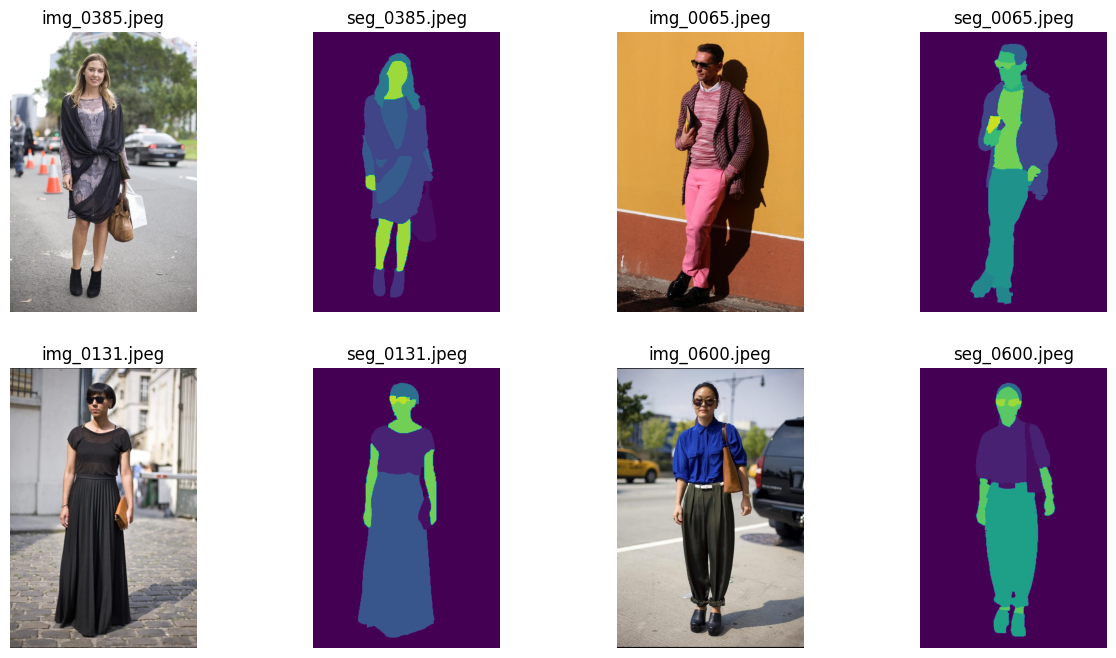

In [5]:
show_imgs=4
idx=np.random.choice(len(df),show_imgs,replace=False)
fig,axes=plt.subplots(show_imgs*2//4,4,figsize=(15,8))
axes=axes.flatten()
for i,ax in enumerate(axes):
  new_i=i//2
  if i%2==0:
    full_path=df.loc[idx[new_i]]['img']
  else:
    full_path=df.loc[idx[new_i]]["mask"]
  ax.imshow(plt.imread(full_path))
  basename=os.path.basename(full_path)
  ax.set_title(basename)
  ax.set_axis_off()

### Create datasets and dataloaders

In [6]:
train_transforms=A.Compose([
    A.Resize(576,576),
    A.RandomCrop(height=512,width=512,always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01,scale_limit=(-0.04,0.04),
                       rotate_limit=(-5,5),p=0.5),
])
test_transforms=A.Compose([
    A.Resize(512,512)
])

class MyDataset(torch.utils.data.Dataset):
  def __init__(self,dataframe,transforms_=None):
    self.df=dataframe
    self.transforms_=transforms_
    self.pre_normalize=v2.Compose([
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])
    self.resize=[512,512]
    self.class_size=59

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    img=cv2.cvtColor(cv2.imread(self.df.iloc[index]['img']),cv2.COLOR_BGR2RGB)
    mask=cv2.imread(self.df.iloc[index]['mask'],cv2.IMREAD_GRAYSCALE)
    mask[mask>self.class_size-1]=0
    aug=self.transforms_(image=img,mask=mask)
    img,mask=aug['image'],aug['mask']
    img=img/255
    img=self.pre_normalize(img)
    img=torch.tensor(img,dtype=torch.float32).permute(2,0,1)
    target=torch.tensor(mask,dtype=torch.long)
    sample={'x':img,'y':target}
    return sample

In [7]:
device=torch.device('cuda' if torch.cuda.is_available else "cpu")
train_df,val_df=train_test_split(df,test_size=0.2)
train_dataset=MyDataset(train_df,train_transforms)
val_dataset=MyDataset(val_df,test_transforms)

BATCH_SIZE=4
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE)

In [8]:
print(f"len train: {len(train_df)}")
print(f"len val: {len(val_df)}")

len train: 800
len val: 200


### Create Model

In [9]:
class_size=59
model=smp.Unet(encoder_name="efficientnet-b4",
               encoder_weights="imagenet",
               in_channels=3,
               classes=class_size,
               )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 229MB/s]


### Training and validation

In [10]:
def train(dataloader,model,loss_fn,optimizer,lr_scheduler,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.train()
  epoch_loss=0
  epoch_iou_score=0
  for batch_i,batch in enumerate(dataloader):
    x,y=batch['x'].to(device),batch['y'].to(device)
    optimizer.zero_grad()
    pred=model(x)
    loss=loss_fn(pred,y)

    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
    y=y.round().long()
    pred=torch.argmax(pred,dim=1)
    tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=class_size)
    iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()
    epoch_iou_score+=iou_score
    lr_scheduler.step()
  return epoch_loss/num_batches,epoch_iou_score/num_batches

def test(dataloader,model,loss_fn,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.eval()
  epoch_loss=0
  epoch_iou_score=0
  with torch.no_grad():
    for batch_i,batch in enumerate(dataloader):
      x,y=batch['x'].to(device),batch['y'].to(device)
      pred=model(x)
      loss=loss_fn(pred,y)
      epoch_loss+=loss.item()
      y=y.round().long()
      pred=torch.argmax(pred,dim=1)
      tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=class_size)
      iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()

      epoch_iou_score+=iou_score
  return epoch_loss/num_batches,epoch_iou_score/num_batches



In [11]:
device=torch.device('cuda' if torch.cuda.is_available else "cpu")
EPOCHS=30
logs={
    'train_loss':[],'val_loss':[],
    'train_iou_score':[],'val_iou_score':[],
}
if not os.path.exists('/content/drive/MyDrive/fashionDataset/checkpoints'):
  os.makedirs("/content/drive/MyDrive/fashionDataset/checkpoints")

loss_fn=smp.losses.DiceLoss(mode="multiclass")

learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
step_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=2000,gamma=0.1)
patience=5
counter=0
best_loss=np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
  train_loss,train_iou_score=train(train_loader,model,loss_fn,optimizer,step_lr_scheduler,device)
  val_loss,val_iou_score=test(val_loader,model,loss_fn,device)
  logs['train_loss'].append(train_loss)
  logs['val_loss'].append(val_loss)
  logs['train_iou_score'].append(train_iou_score)
  logs['val_iou_score'].append(val_iou_score)

  print(f'EPOCH: {str(epoch+1).zfill(3)} \
  train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
  train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
  lr: {optimizer.param_groups[0]["lr"]}')
  torch.save(model.state_dict(),"/content/drive/MyDrive/fashionDataset/checkpoints/last.pth")

  if val_loss<best_loss:
    counter=0

    best_loss=val_loss
    torch.save(model.state_dict(),"/content/drive/MyDrive/fashionDataset/checkpoints/best.pth")
  else:
    counter+=1

  if counter>=patience:
    print("Early stopping")
    break

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 001   train_loss: 0.9358, val_loss: 0.9041   train_iou_score: 0.515, val_iou_score: 0.649   lr: 0.001


  3%|▎         | 1/30 [06:07<2:57:36, 367.46s/it]

EPOCH: 002   train_loss: 0.8856, val_loss: 0.8802   train_iou_score: 0.627, val_iou_score: 0.670   lr: 0.001


  7%|▋         | 2/30 [06:53<1:23:14, 178.36s/it]

EPOCH: 003   train_loss: 0.8693, val_loss: 0.8647   train_iou_score: 0.641, val_iou_score: 0.672   lr: 0.001


 10%|█         | 3/30 [07:39<53:03, 117.90s/it]  

EPOCH: 004   train_loss: 0.8600, val_loss: 0.8560   train_iou_score: 0.650, val_iou_score: 0.700   lr: 0.001


 13%|█▎        | 4/30 [08:25<38:51, 89.65s/it] 

EPOCH: 005   train_loss: 0.8539, val_loss: 0.8562   train_iou_score: 0.656, val_iou_score: 0.704   lr: 0.001


 17%|█▋        | 5/30 [09:11<30:44, 73.77s/it]

EPOCH: 006   train_loss: 0.8500, val_loss: 0.8484   train_iou_score: 0.654, val_iou_score: 0.696   lr: 0.001


 20%|██        | 6/30 [09:56<25:40, 64.19s/it]

EPOCH: 007   train_loss: 0.8445, val_loss: 0.8524   train_iou_score: 0.660, val_iou_score: 0.701   lr: 0.001


 23%|██▎       | 7/30 [10:42<22:15, 58.09s/it]

EPOCH: 008   train_loss: 0.8456, val_loss: 0.8457   train_iou_score: 0.664, val_iou_score: 0.702   lr: 0.001


 27%|██▋       | 8/30 [11:28<19:52, 54.21s/it]

EPOCH: 009   train_loss: 0.8391, val_loss: 0.8432   train_iou_score: 0.672, val_iou_score: 0.703   lr: 0.001


 30%|███       | 9/30 [12:14<18:04, 51.65s/it]

EPOCH: 010   train_loss: 0.8364, val_loss: 0.8381   train_iou_score: 0.676, val_iou_score: 0.721   lr: 0.0001


 33%|███▎      | 10/30 [13:00<16:38, 49.92s/it]

EPOCH: 011   train_loss: 0.8239, val_loss: 0.8293   train_iou_score: 0.693, val_iou_score: 0.734   lr: 0.0001


 37%|███▋      | 11/30 [13:46<15:23, 48.59s/it]

EPOCH: 012   train_loss: 0.8234, val_loss: 0.8282   train_iou_score: 0.700, val_iou_score: 0.734   lr: 0.0001


 40%|████      | 12/30 [14:31<14:18, 47.70s/it]

EPOCH: 013   train_loss: 0.8236, val_loss: 0.8277   train_iou_score: 0.699, val_iou_score: 0.732   lr: 0.0001


 43%|████▎     | 13/30 [15:17<13:21, 47.15s/it]

EPOCH: 014   train_loss: 0.8186, val_loss: 0.8255   train_iou_score: 0.704, val_iou_score: 0.739   lr: 0.0001


 47%|████▋     | 14/30 [16:03<12:28, 46.80s/it]

EPOCH: 015   train_loss: 0.8175, val_loss: 0.8274   train_iou_score: 0.707, val_iou_score: 0.735   lr: 0.0001


 50%|█████     | 15/30 [16:48<11:34, 46.29s/it]

EPOCH: 016   train_loss: 0.8173, val_loss: 0.8254   train_iou_score: 0.708, val_iou_score: 0.738   lr: 0.0001


 53%|█████▎    | 16/30 [17:34<10:47, 46.24s/it]

EPOCH: 017   train_loss: 0.8157, val_loss: 0.8238   train_iou_score: 0.712, val_iou_score: 0.743   lr: 0.0001


 57%|█████▋    | 17/30 [18:20<09:59, 46.15s/it]

EPOCH: 018   train_loss: 0.8166, val_loss: 0.8241   train_iou_score: 0.713, val_iou_score: 0.739   lr: 0.0001


 60%|██████    | 18/30 [19:06<09:12, 46.02s/it]

EPOCH: 019   train_loss: 0.8145, val_loss: 0.8248   train_iou_score: 0.711, val_iou_score: 0.739   lr: 0.0001


 63%|██████▎   | 19/30 [19:51<08:24, 45.87s/it]

EPOCH: 020   train_loss: 0.8125, val_loss: 0.8245   train_iou_score: 0.718, val_iou_score: 0.741   lr: 1e-05


 67%|██████▋   | 20/30 [20:37<07:37, 45.76s/it]

EPOCH: 021   train_loss: 0.8130, val_loss: 0.8240   train_iou_score: 0.721, val_iou_score: 0.740   lr: 1e-05


 70%|███████   | 21/30 [21:23<06:51, 45.76s/it]

EPOCH: 022   train_loss: 0.8101, val_loss: 0.8238   train_iou_score: 0.719, val_iou_score: 0.740   lr: 1e-05


 73%|███████▎  | 22/30 [22:08<06:05, 45.73s/it]

EPOCH: 023   train_loss: 0.8128, val_loss: 0.8235   train_iou_score: 0.720, val_iou_score: 0.741   lr: 1e-05


 77%|███████▋  | 23/30 [22:54<05:20, 45.79s/it]

EPOCH: 024   train_loss: 0.8093, val_loss: 0.8234   train_iou_score: 0.721, val_iou_score: 0.741   lr: 1e-05


 80%|████████  | 24/30 [23:40<04:35, 45.88s/it]

EPOCH: 025   train_loss: 0.8074, val_loss: 0.8233   train_iou_score: 0.721, val_iou_score: 0.741   lr: 1e-05


 83%|████████▎ | 25/30 [24:27<03:49, 45.96s/it]

EPOCH: 026   train_loss: 0.8073, val_loss: 0.8235   train_iou_score: 0.722, val_iou_score: 0.741   lr: 1e-05


 87%|████████▋ | 26/30 [25:12<03:02, 45.75s/it]

EPOCH: 027   train_loss: 0.8092, val_loss: 0.8233   train_iou_score: 0.723, val_iou_score: 0.740   lr: 1e-05


 90%|█████████ | 27/30 [25:57<02:17, 45.71s/it]

EPOCH: 028   train_loss: 0.8121, val_loss: 0.8231   train_iou_score: 0.720, val_iou_score: 0.742   lr: 1e-05


 93%|█████████▎| 28/30 [26:44<01:31, 45.85s/it]

EPOCH: 029   train_loss: 0.8078, val_loss: 0.8234   train_iou_score: 0.719, val_iou_score: 0.740   lr: 1e-05


 97%|█████████▋| 29/30 [27:30<00:45, 45.91s/it]

EPOCH: 030   train_loss: 0.8094, val_loss: 0.8232   train_iou_score: 0.721, val_iou_score: 0.742   lr: 1.0000000000000002e-06


100%|██████████| 30/30 [28:15<00:00, 56.52s/it]


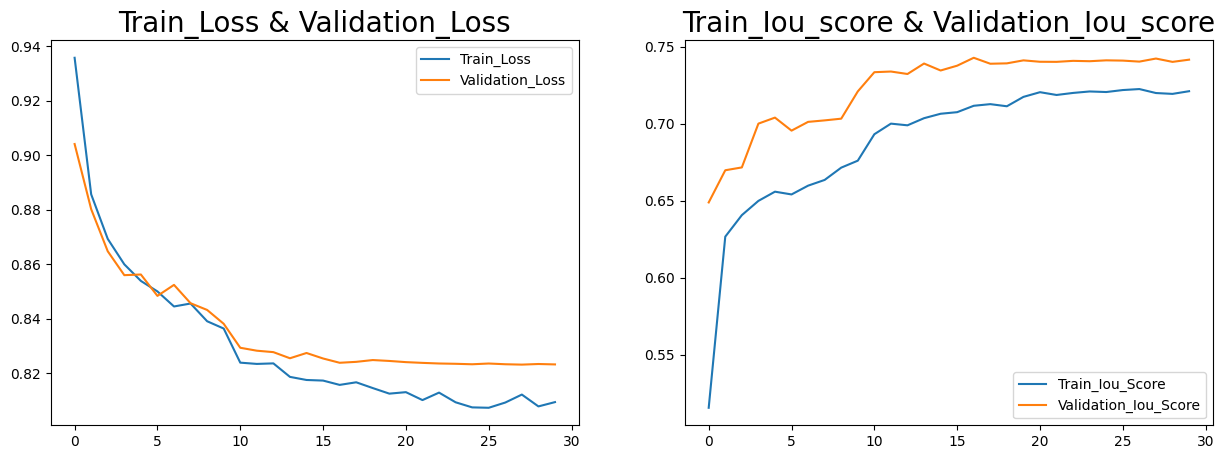

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

### Inference

In [13]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 59

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['img']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['mask'],cv2.IMREAD_GRAYSCALE)
        mask[mask > self.class_size-1] = 0
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        mask_view = np.copy(mask)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample


test_dataset = TestDataset(val_df, test_transforms)


<ipython-input-14-38236e7d5903>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/fashionDataset/checkpoints/best.pth

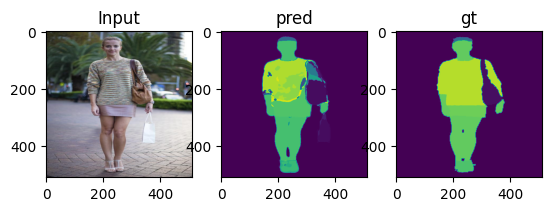

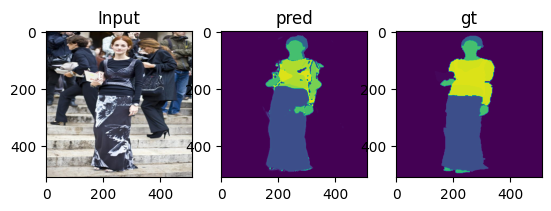

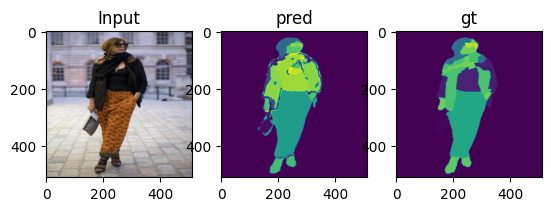

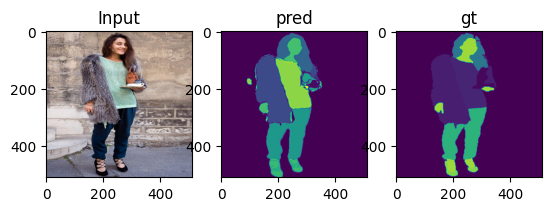

In [14]:
model.load_state_dict(torch.load("/content/drive/MyDrive/fashionDataset/checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.argmax(pred,dim=1).squeeze(0)
    pred = pred.data.cpu().numpy()
    # print(f'pred_2.shape: {pred.shape}')
    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_view)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()